# Introduction to PyTorch

Overview of the main features of PyTorch:
- autograd
- dynamic computation graph
- model classes

## Tensor
In Numpy, you may have an array that has three dimensions. That is, technically speaking, a tensor. <br/>
A **scalar** (a single number) has zero dimensions, a **vector** has one dimension, a **matrix** has two dimensions and a **tensor** has three or more dimensions.

In [95]:
import torch
import torch.optim as optim
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [96]:
x = torch.ones([2,2])
x

tensor([[1., 1.],
        [1., 1.]])

## Parameters

What distinguishes a `tensor` used for data — like the ones we’ve just created — from a tensor used as a (trainable) `parameter`/`weight`?
The latter tensors require the computation of its gradients, so we can update their values (the parameters’ values, that is). That’s what the requires_grad=True argument is good for. It tells PyTorch we want it to compute gradients for us.

`torch.Tensor` is the central class of the package. If you set its attribute .requires_grad as True, it starts to track all operations on it. When you finish your computation you can call `.backward()` and have all the gradients computed automatically. The gradient for this tensor will be accumulated into .grad attribute.

In [97]:
x.requires_grad_()
x

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

*NOTE. In PyTorch, every method that ends with an underscore (_) makes changes in-place, meaning, they will modify the underlying variable.*

or cerate directly as a paramenter:

In [98]:
x = torch.ones([2,2], requires_grad=True)
x

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

A parameter mantains the history of how it was created, the expression that created, or the computation graph that produced it.

This supports automatic differentiation by means of `Autograd`

## Autograd

Autograd is PyTorch’s automatic differentiation package. Thanks to it, we don’t need to worry about partial derivatives, chain rule or anything like it.
So, how do we tell PyTorch to do its thing and compute all gradients?<br/>
That’s what the method `backward()` does.

In [99]:
x = torch.ones([2,2], requires_grad=True)
y = x + 1
z = y * y * 3
print('x:', x)
print('y:', y)
print('z:', z)

x: tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
y: tensor([[2., 2.],
        [2., 2.]], grad_fn=<AddBackward0>)
z: tensor([[12., 12.],
        [12., 12.]], grad_fn=<MulBackward0>)


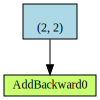

In [100]:
make_dot(y)

Compute the gradients:

In [101]:
z.backward(torch.ones([2,2]))

The gradient of<br>
$z = (x+1)(x+1)3$ <br>
is <br>
$\delta{z}/\delta{x} = 3x(x+1)+3(x+1)x$

In [102]:
x.grad

tensor([[12., 12.],
        [12., 12.]])

In [103]:
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
z = y * y * 3
print(z)
z.backward(torch.ones([2,2]))
x.grad

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>)


tensor([[18., 18.],
        [18., 18.]])

In [111]:
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
z = y * y * 3
o = z.mean()
print('x:', x)
print('y:', y)
print('z:', z)
print('o:', o)
o.backward(torch.tensor(1.))
x.grad

x: tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
y: tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
z: tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>)
o: tensor(27., grad_fn=<MeanBackward0>)


tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])

$o = \frac{1}{4}\sum{i}{z_i}$ <br>
$z_i = 3(x+2)^2$ <br>
$\frac{\delta o}{\delta x_i} = \frac{1}{4} \cdot 3 \cdot 2 (x_i+2) = \frac{3}{2}(x_i+2) = \frac{9}{2} = 4.5$

# Generate some training data

In [112]:
import numpy as np

# Data Generation
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)

# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

Plot the dataset

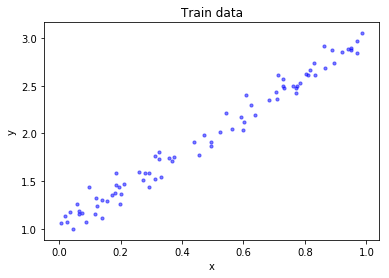

In [113]:
%matplotlib inline  
import matplotlib.pyplot as plt

plt.scatter(x_train, y_train, s=10, c=('blue'), alpha=0.5)
plt.title('Train data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# The Computation Graph

Turn the data into tensors

In [114]:
x_train_pt = torch.from_numpy(x_train).float()
y_train_pt = torch.from_numpy(y_train).float()

x_val_pt = torch.from_numpy(x_val).float()
y_val_pt = torch.from_numpy(y_val).float()

In [115]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

yhat = a + b * x_train_pt
error = y_train_pt - yhat
loss = (error ** 2).mean()

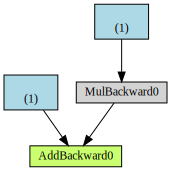

In [116]:
from torchviz import make_dot
make_dot(yhat)

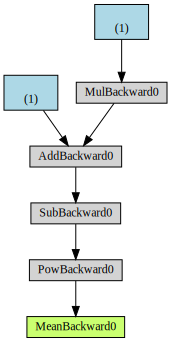

In [82]:
make_dot(loss)

Let’s take a closer look at its components:
- **blue** boxes: these correspond to the tensors we use as parameters, the ones we’re asking PyTorch to compute gradients for;
- **gray** box: a Python operation that involves a gradient-computing tensor or its dependencies;
- **green** box: the same as the gray box, except it is the starting point for the computation of gradients (assuming the backward()method is called from the variable used to visualize the graph)— they are computed from the bottom-up in a graph.

# Regression

We can perfomr linera regression on the data by gradient descent, in order to minimize the mean suare loss

In [119]:
lr = 1e-1
n_epochs = 1000

torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

for epoch in range(n_epochs):
    yhat = a + b * x_train_pt
    error = y_train_pt - yhat
    loss = (error ** 2).mean()
    
    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward()
    
    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
    
    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    a.grad.zero_()
    b.grad.zero_()
    
print(a, b)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


## Optimizer

We can perform interpolation using an optimizer

In [120]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_pt
    error = y_train_pt - yhat
    loss = (error ** 2).mean()

    loss.backward()    
    
    # Gradient
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    optimizer.step()
    
    # No more telling PyTorch to let gradients go!
    # a.grad.zero_()
    # b.grad.zero_()
    optimizer.zero_grad()
    
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


# Model
In PyTorch, a model is represented by a regular Python class that inherits from the Module class.
The most fundamental methods it needs to implement are:
- __init__(self): it defines the parts that make up the model —in our case, two parameters, a and b.

*NOTE: You are not limited to defining parameters, though… models can contain other models (or layers) as its attributes as well, so you can easily nest them. We’ll see an example of this shortly as well.*

- forward(self, x): it performs the actual computation, that is, it outputs a prediction, given the input x.

*NOTE. You should NOT call the forward(x) method, though. You should call the whole model itself, as in model(x) to perform a forward pass and output predictions.*

Let’s build a proper (yet simple) model for our regression task. It should look like this:

In [90]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.a + self.b * x

## Train the model

In [121]:
torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = LinearRegression().to(device)
# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # What is this?!?
    model.train()

    yhat = model(x_train_pt)
    
    loss = loss_fn(y_train_pt, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(model.state_dict())

OrderedDict([('a', tensor([0.3367])), ('b', tensor([0.1288]))])
OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


## Layers

Let’s use PyTorch’s Linear model as an attribute of our own, thus creating a nested model.

In [94]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)

## Sequential
Simiarly to `Keras`, one can use a `Sequential` model, to define
straightforward models, that use run-of-the-mill layers, where the output of a layer is sequentially fed as an input to the next.

In our case, we would build a `Sequential` model with a single argument, that is, the `Linear` layer we used to train our linear regression. The model would look like this:

In [ ]:
model = nn.Sequential(nn.Linear(1, 1)).to(device)